MainProcess


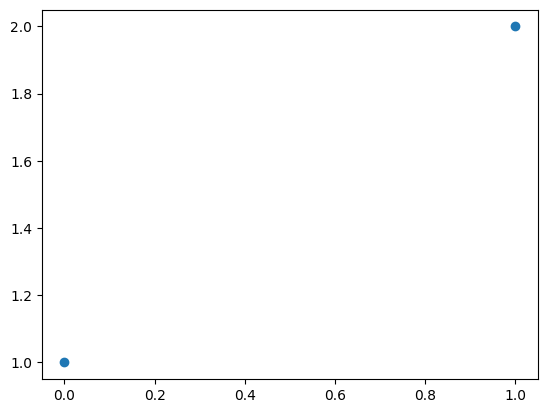

In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core')
sys.path.append('/flagellar/input/my-flg-library/')
import flg_support as fls
import importlib
import numpy as np
import flg_diagnostics
import flg_numerics
import matplotlib.pyplot as plt
import glob
import copy
import flg_preprocess
import os
fls.profiling=False
plt.scatter([0,1],[1,2])

In [2]:
files = glob.glob(fls.result_dir + '/many_abbr_full/Baseline_0M*')
models = [fls.dill_load(f) for f in files]
models = sorted(models, key=lambda d:d.trained_model.seed)

In [3]:
todo = slice(None)
data = copy.deepcopy(models[0].inferred_test_data[todo])
train_data = fls.load_all_train_data()+fls.load_all_test_data()
train_data_new = []
for t in models[0].train_data:
    for d in train_data:
        if t.name == d.name:
            train_data_new.append(d)
models[0].train_data = train_data_new  
test_data_new = []
for t in models[0].test_data:
    for d in train_data:
        if t.name == d.name:
            test_data_new.append(d)
models[0].test_data = test_data_new  

In [4]:
# for m in models[0:1]:
#     m.trained_model.step1Labels.relative_confidence_threshold = 0.001
#     m.inferred_test_data = m.trained_model.infer(m.test_data)

In [5]:
models[0].trained_model.step1Labels.seed

0

In [ ]:
highest_false_score = []
real_score = []
data_list = []
for i_type in [3]:#range(4):
    model = copy.deepcopy(models[0].untrained_model)
    model.step1Labels.relative_confidence_threshold = 0.01
    #model.step1Labels.n_epochs = 2
    #m.step2Motors.distance_threshold = 10.
    if i_type == 0:
        # baseline
        pass
    elif i_type==1:
        # blur
        model.step1Labels.preprocessor = flg_preprocess.Preprocessor2()
    elif i_type==2:
        # no resize
        model.step1Labels.preprocessor = flg_preprocess.Preprocessor2()
        model.step1Labels.preprocessor.target_voxel_spacing = 20.
        model.step1Labels.box_size = 18
        model.step1Labels.prevent_ultralytics_resize = True        
    elif i_type==3:
        # negative labels
        model.step1Labels.preprocessor = flg_preprocess.Preprocessor2()
        model.step1Labels.preprocessor.target_voxel_spacing = 20.
        model.step1Labels.box_size = 18
        model.step1Labels.prevent_ultralytics_resize = True     
        model.step1Labels.negative_label_threshold = 0.6
        model.step1Labels.negative_slice_ratio = 0.        
    model.run_in_parallel = False   
    model_file = fls.temp_dir + 'model_' + str(i_type) + '.pickle'
    if not os.path.isfile(model_file):
        print('!!!')
        model.step1Labels.trust = 0
        model.train(models[0].train_data, models[0].test_data)
        fls.dill_save(model_file, model)
    model = fls.dill_load(model_file)
    #model = fls.dill_load(fls.temp_dir + 'model_' + str(i_type) + '.pickle')
    data_file = fls.temp_dir + 'data_' + str(i_type) + '.pickle'
    if not os.path.isfile(data_file):        
        inferred_data = model.infer(models[0].test_data[todo])
        fls.dill_save(data_file, inferred_data)
    inferred_data = fls.dill_load(data_file)    
    for d in inferred_data:
        d.labels_unfiltered = d.labels_unfiltered2
    fls.mark_tf_pn(inferred_data, models[0].test_data[todo])
    data_list.append(inferred_data)
    this_highest_false_score = []
    this_real_score = []
    for i,r in zip(inferred_data, models[0].test_data[todo]):
        false_positives = i.labels_unfiltered[i.labels_unfiltered['tf_pn']==1.]
        if len(false_positives)>0:
            this_highest_false_score.append(np.max(false_positives['confidence']))
        else:
            this_highest_false_score.append(0)
        if len(r.labels)>0:
            true_positives = i.labels_unfiltered[i.labels_unfiltered['tf_pn']==0.]
            if len(true_positives)>0:
                this_real_score.append(np.max(true_positives['confidence']))
            else:
                this_real_score.append(0)
    highest_false_score.append(this_highest_false_score)
    real_score.append(this_real_score)


!!!
CompletedProcess(args=['pip', 'uninstall', '-y', 'albumentations'], returncode=0)


  0%|          | 0/575 [00:00<?, ?it/s]

Clearing pytorch


/opt/conda/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


  0%|          | 0/72 [00:00<?, ?it/s]


Preprocessing Complete:
- Training data: 575 tomograms, 0 motors, 0 slices
- Validation data: 72 tomograms, 0 motors, 0 slices
- Dataset directory: /flagellar/temp//yolo_dataset/
- YAML configuration: /flagellar/temp//yolo_dataset/dataset.yaml

Ready for YOLO training!
Starting YOLO training process...
Created new YAML at /flagellar/temp/training.yaml
Using YAML file: /flagellar/temp/training.yaml
YAML contents:
names:
  0: motor
path: /flagellar/temp//yolo_dataset/
train: images/train
val: images/val


Starting YOLO training...
New https://pypi.org/project/ultralytics/8.3.127 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'crop_fraction' is deprecated and will be removed in in the future.
Ultralytics 8.3.126 🚀 Python-3.11.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=None, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy

train: Scanning /flagellar/temp/yolo_dataset/labels/train... 655 images, 335 backgrounds, 2 corrupt: 100%|██████████| 655/655 [00:00<00:00, 2909.70it/s]

train: /flagellar/temp/yolo_dataset/images/train/tomo_a5ac23_z0169.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0908]
train: /flagellar/temp/yolo_dataset/images/train/tomo_a5ac23_z0171.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0908]
train: New cache created: /flagellar/temp/yolo_dataset/labels/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1520.4±922.0 MB/s, size: 110.0 KB)


val: Scanning /flagellar/temp/yolo_dataset/labels/val... 71 images, 29 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<00:00, 2674.89it/s]

val: New cache created: /flagellar/temp/yolo_dataset/labels/val.cache


Plotting labels to /flagellar/temp/yolo_weights/motor_detector/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.00046875), 227 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /flagellar/temp/yolo_weights/motor_detector
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.83G       4.07      64.19      1.714          8        640: 100%|██████████| 55/55 [00:06<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.13it/s]

                   all         71         42   0.000772       0.19   0.000659   0.000286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.17G       3.37      4.647       1.27          1        640: 100%|██████████| 55/55 [00:05<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 18.41it/s]

                   all         71         42     0.0913     0.0238     0.0392    0.00968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.17G      3.022      3.552        1.2          8        640:  76%|███████▋  | 42/55 [00:03<00:01, 11.33it/s]

In [ ]:
for d in data_list:
    n_corr=0
    n_total=0
    for i,r in zip(d, models[0].test_data[todo]):
        if len(r.labels)>0:# and 'tom' in r.name:
            n_total+=1
            ind = np.argmax(i.labels_unfiltered['confidence'])
            if (i.labels_unfiltered['tf_pn'].tolist()[ind])==0.:
                n_corr += 1
    print(n_corr/n_total)
    #print(i.labels_unfiltered)

In [ ]:
i_baseline = 2; i_new = 3;

In [ ]:
plt.scatter(highest_false_score[i_baseline], highest_false_score[i_new])
plt.xlabel('Highest false score baseline')
plt.ylabel('Highest false score new')
plt.grid(True)
plt.axline((0,0),slope=1)

In [ ]:
plt.scatter(real_score[i_baseline], real_score[i_new])
plt.xlabel('True score baseline')
plt.ylabel('True score new')
plt.grid(True)
plt.axline((0,0),slope=1)

In [ ]:
xx=(np.argwhere(np.logical_and(np.array(real_score[i_baseline])>0.6, np.array(real_score[i_new])<0.1))).flatten()
xx

In [ ]:
#cur_id = 87
cur_id = 0
for ii in range(len(models[0].test_data[todo])):
    if len(models[0].test_data[todo][ii].labels)>0:     
        if cur_id in xx:
            print(models[0].test_data[todo][ii].name,ii,real_score[i_baseline][cur_id],real_score[i_new][cur_id])
        cur_id+=1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# flatten the two arrays into one to get global bin edges
all_scores = np.concatenate([highest_false_score[i_baseline], highest_false_score[i_new]])
# choose number of bins (e.g. 30) or compute automatically
bins = np.histogram_bin_edges(all_scores, bins=30)

plt.figure(figsize=(8, 5))
plt.hist(highest_false_score[i_baseline], bins=bins, cumulative=True, alpha=0.5, label='Original')
plt.hist(highest_false_score[i_new], bins=bins, cumulative=True, alpha=0.5, label='New')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Overlayed Histograms of Highest False Scores - lower is better')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# flatten the two arrays into one to get global bin edges
all_scores = np.concatenate([real_score[i_baseline], real_score[i_new]])
# choose number of bins (e.g. 30) or compute automatically
bins = np.histogram_bin_edges(all_scores, bins=30)

plt.figure(figsize=(8, 5))
plt.hist(real_score[i_baseline], bins=bins, cumulative=True, alpha=0.5, label='Original')
plt.hist(real_score[i_new], bins=bins, cumulative=True, alpha=0.5, label='New')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Overlayed Histograms of True Scores - higher is better')
plt.legend()
plt.tight_layout()
plt.show()